In [ ]:
# ======================= Cell 1: Imports & Download ======================= #
# NOTE: Paste this cell in your notebook and run top-to-bottom.

import os, re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -- Download dataset (same style as your snippet) --
import kagglehub
path = kagglehub.dataset_download("ricgomes/global-fashion-retail-stores-dataset")
print("Path to dataset files:", path)

100%|██████████| 224M/224M [00:01<00:00, 167MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ricgomes/global-fashion-retail-stores-dataset/versions/24


In [ ]:
# ======================= Cell 2: Load Transactions ======================= #
# Robustly find the Transactions file with different casings
CAND = ["Transactions.csv", "transactions.csv", "TRANSACTIONS.csv"]
tx_fp = None
for c in CAND:
    p = os.path.join(path, c)
    if os.path.exists(p):
        tx_fp = p
        break
if tx_fp is None:
    raise FileNotFoundError(
        f"Không tìm thấy file Transactions. Đặt lại tên file trong thư mục: {path}"
    )

df = pd.read_csv(tx_fp)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns)[:10], "...")

Loaded shape: (6416827, 19)
Columns: ['Invoice ID', 'Line', 'Customer ID', 'Product ID', 'Size', 'Color', 'Unit Price', 'Quantity', 'Date', 'Discount'] ...


In [ ]:
# ======================= Cell 3: Preprocessing (Currency → USD) ======================= #
import re

# 0) Config nhỏ
DROP_UNKNOWN_FX = False  # True = loại bỏ các dòng không nhận diện được tỷ giá

# 1) Chuẩn hóa tên cột
def norm_col(c):
    return str(c).strip().replace("\n", " ").replace("\r", " ")

df.columns = [norm_col(c) for c in df.columns]

# 2) Tên cột chuẩn
C_DATE        = "Date"
C_INV_ID      = "Invoice ID"
C_LINE_TOTAL  = "Line Total"
C_INV_TOTAL   = "Invoice Total"
C_UNIT_PRICE  = "Unit Price"
C_CCY         = "Currency"
C_CCY_SYM     = "Currency Symbol"

if C_DATE not in df.columns:
    raise ValueError(f"Thiếu cột '{C_DATE}' trong Transactions. Hiện có: {df.columns.tolist()}")

# 3) Parse Date
df[C_DATE] = pd.to_datetime(df[C_DATE], errors="coerce")
df = df.dropna(subset=[C_DATE]).copy()

# 4) Clean tiền tệ → số
def money_to_numeric(series):
    if series is None:
        return None
    s = pd.Series(series).astype(str)
    s = s.str.replace(r"[^\d\-\.,]", "", regex=True)  # giữ số, '-' '.' ','
    s = s.str.replace(",", "", regex=False)           # bỏ dấu phẩy nghìn
    return pd.to_numeric(s, errors="coerce")

# 5) Bảng FX (USD/1 đơn vị ngoại tệ) — cập nhật theo ngày tham chiếu của bạn nếu cần
FX_USD = {
    "USD": 1.00, "EUR": 1.08, "GBP": 1.25, "JPY": 0.0068, "CNY": 0.14,
    "AUD": 0.66, "CAD": 0.73, "CHF": 1.10, "SGD": 0.74, "HKD": 0.13,
    "MXN": 0.055, "BRL": 0.20, "INR": 0.012, "KRW": 0.00075, "TWD": 0.031,
    "THB": 0.027, "VND": 0.000041, "PLN": 0.25, "SEK": 0.091, "NOK": 0.093,
    "DKK": 0.145, "TRY": 0.033, "AED": 0.272, "ZAR": 0.053, "RUB": 0.011,
}

# Ký hiệu → mã CCY (mặc định '¥' là JPY; đổi nếu dữ liệu của bạn là CNY)
SYMBOL_TO_CCY = {
    "$": "USD", "US$": "USD", "€": "EUR", "£": "GBP",
    "¥": "JPY", "CN¥": "CNY", "฿": "THB", "₫": "VND", "₩": "KRW",
    "A$": "AUD", "C$": "CAD", "S$": "SGD", "HK$": "HKD", "R$": "BRL",
    "₹": "INR", "zł": "PLN", "Fr": "CHF", "CHF": "CHF", "₺": "TRY",
    "AED": "AED", "MX$": "MXN",
}

def normalize_currency(row):
    code = str(row.get(C_CCY, "")).strip().upper()
    sym  = str(row.get(C_CCY_SYM, "")).strip()
    if code in FX_USD:  # đã là ISO-3
        return code
    guess = re.sub(r"[^A-Z]", "", code)
    if guess in FX_USD:
        return guess
    if sym in SYMBOL_TO_CCY:
        return SYMBOL_TO_CCY[sym]
    return "USD"  # fallback

# 6) Xác định mã và tỷ giá
if (C_CCY in df.columns) or (C_CCY_SYM in df.columns):
    df["Currency_norm"] = df.apply(normalize_currency, axis=1)
else:
    df["Currency_norm"] = "USD"

rate = df["Currency_norm"].map(FX_USD)

# (tuỳ chọn) loại bỏ dòng không map được FX
if DROP_UNKNOWN_FX:
    bad = df[rate.isna()]
    if len(bad):
        print(f"Loại {len(bad)} dòng vì không map được FX: {sorted(bad['Currency_norm'].unique())}")
    df = df[~rate.isna()].copy()
    rate = df["Currency_norm"].map(FX_USD)

# Nếu vẫn còn NaN → dùng 1.0 và cảnh báo
if rate.isna().any():
    unk = sorted(df.loc[rate.isna(), "Currency_norm"].unique())
    print("⚠️  Không có tỷ giá cho:", unk, "→ dùng 1.0 (không đổi). Hãy bổ sung FX_USD nếu cần.")
    rate = rate.fillna(1.0)

# 7) Quy đổi sang USD tại chỗ
for col in [C_LINE_TOTAL, C_INV_TOTAL, C_UNIT_PRICE]:
    if col in df.columns:
        df[col] = money_to_numeric(df[col]) * rate.values

df["Currency_USD_rate"] = rate.values
df["Currency_standard"] = "USD"

print("Currency_norm (ví dụ):", df["Currency_norm"].dropna().unique()[:10])
print("Đã quy đổi các cột tiền về USD:", [c for c in [C_LINE_TOTAL, C_INV_TOTAL, C_UNIT_PRICE] if c in df.columns])


Currency_norm (ví dụ): ['USD' 'CNY' 'EUR' 'GBP']
Đã quy đổi các cột tiền về USD: ['Line Total', 'Invoice Total', 'Unit Price']


In [ ]:
# ======================= Cell 4: Build Daily Revenue (USD) ======================= #
C_DATE       = "Date"
C_INV_ID     = "Invoice ID"
C_LINE_TOTAL = "Line Total"     # đã là USD sau Cell 3
C_INV_TOTAL  = "Invoice Total"  # đã là USD sau Cell 3

# Sanity-check: mọi dòng đều đã gắn chuẩn USD
if "Currency_standard" in df.columns:
    assert (df["Currency_standard"] == "USD").all(), "Phát hiện dòng chưa chuẩn USD!"

# Cách A: sum(Line Total) theo ngày
daily_A = None
if C_LINE_TOTAL in df.columns:
    daily_A = (
        df.groupby(df[C_DATE].dt.date)[C_LINE_TOTAL]
          .sum()
          .rename("revenue_A_line_sum_usd")
          .to_frame()
    )

# Cách B: sum(Invoice Total) theo ngày (mỗi hóa đơn 1 lần)
daily_B = None
if C_INV_TOTAL in df.columns and C_INV_ID in df.columns:
    inv_level = (
        df.groupby([C_INV_ID], as_index=False)
          .agg({C_INV_TOTAL:"max", C_DATE:"min"})
    )
    daily_B = (
        inv_level.groupby(inv_level[C_DATE].dt.date)[C_INV_TOTAL]
                 .sum()
                 .rename("revenue_B_invoice_sum_usd")
                 .to_frame()
    )

if daily_A is None and daily_B is None:
    raise ValueError("Thiếu cả 'Line Total' và 'Invoice Total' để tính doanh thu ngày (USD).")

# So sánh & chọn
if daily_A is not None and daily_B is not None:
    joined = daily_A.join(daily_B, how="outer").fillna(0.0)
    denom = np.where(joined["revenue_B_invoice_sum_usd"] == 0, 1.0, joined["revenue_B_invoice_sum_usd"])
    rel_diff = np.abs(joined["revenue_A_line_sum_usd"] - joined["revenue_B_invoice_sum_usd"]) / denom
    mean_rel_diff = float(rel_diff.mean())
    print(f"Chênh lệch A vs B (USD): {mean_rel_diff:.2%}")

    if mean_rel_diff > 0.05:
        print("⚠️  >5% → dùng CÁCH A (sum Line Total, USD).")
        daily = joined[["revenue_A_line_sum_usd"]].rename(columns={"revenue_A_line_sum_usd":"revenue"})
    else:
        daily = joined[["revenue_B_invoice_sum_usd"]].rename(columns={"revenue_B_invoice_sum_usd":"revenue"})
else:
    daily = (daily_A or daily_B).rename(columns=lambda c: "revenue")

# Chuẩn hóa index ngày liên tục
daily.index = pd.to_datetime(daily.index)
daily = daily.sort_index()
full_idx = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
daily = daily.reindex(full_idx, fill_value=0.0)
daily.index.name = "date"

print("Doanh thu ngày (USD) — ví dụ:")
display(daily.head())


Chênh lệch A vs B (USD): 0.60%
Doanh thu ngày (USD) — ví dụ:


,revenue
date,
2023-01-01,741025.3150
2023-01-02,172046.9144
2023-01-03,154395.8828
2023-01-04,159579.5419
2023-01-05,152879.7995


In [ ]:
# ======================= Cell 5: Feature Engineering ======================= #
def make_features(series: pd.Series, lags=(1,7,14,28), roll_windows=(7,14,28)) -> pd.DataFrame:
    df_feat = pd.DataFrame({"date": series.index, "y": series.values}).set_index("date")

    # Lags
    for L in lags:
        df_feat[f"lag_{L}"] = df_feat["y"].shift(L)

    # Rolling (shifted to avoid leakage)
    for W in roll_windows:
        df_feat[f"rollmean_{W}"] = df_feat["y"].shift(1).rolling(W, min_periods=max(2, W//2)).mean()
        df_feat[f"rollstd_{W}"]  = df_feat["y"].shift(1).rolling(W, min_periods=max(2, W//2)).std()

    # Calendar features
    idx = df_feat.index
    df_feat["dow"] = idx.dayofweek         # 0=Mon .. 6=Sun
    df_feat["dom"] = idx.day
    df_feat["month"] = idx.month
    df_feat["is_weekend"] = (df_feat["dow"] >= 5).astype(int)

    df_feat = df_feat.dropna()
    return df_feat

feat_df = make_features(daily["revenue"])
print("Feature shape:", feat_df.shape)
display(feat_df.head())

Feature shape: (780, 15)


,y,lag_1,lag_7,lag_14,lag_28,rollmean_7,rollstd_7,rollmean_14,rollstd_14,rollmean_28,rollstd_28,dow,dom,month,is_weekend
date,,,,,,,,,,,,,,,
2023-01-29,237984.0267,236689.7166,312174.5493,247683.2406,741025.3150,165124.744600,77839.811795,164240.247029,65685.514455,190500.521661,124724.323926,6,29,1,1
2023-01-30,120755.1749,237984.0267,118119.5716,174891.7886,172046.9144,154526.098514,56646.165853,163547.446036,64782.666698,172534.761364,63873.675791,0,30,1,0
2023-01-31,122556.8466,120755.1749,120175.3166,123240.7220,154395.8828,154902.613271,56371.943925,159680.545057,65663.163889,170702.913525,64619.336434,1,31,1,0
2023-02-01,125722.9388,122556.8466,125686.7861,120083.4710,159579.5419,155242.831843,56134.109681,159631.696814,65692.605292,169565.805089,65194.496298,2,1,2,0
2023-02-02,122864.3788,125722.9388,124666.4124,117836.4816,152879.7995,155247.996514,56130.938701,160034.515943,65448.282043,168356.640693,65698.592538,3,2,2,0


In [ ]:
# ======================= Cell 6: Metrics ======================= #
def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < 1e-8, 1.0, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred)
    denom = np.where(denom < 1e-8, 1.0, denom)
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def evaluate(y_true, y_pred):
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAPE%": float(mape(y_true, y_pred)),
        "sMAPE%": float(smape(y_true, y_pred)),
    }

In [ ]:
# ======================= Cell: Train/Val/Test 70/20/10 (time-ordered) ======================= #
# Dùng đúng thứ tự thời gian: train (đầu chuỗi) → val (giữa) → test (cuối)
# Áp dụng cho DataFrame feat_df với cột target "y"

X_all = feat_df.drop(columns=["y"])
y_all = feat_df["y"].copy()
n = len(feat_df)

train_ratio, val_ratio, test_ratio = 0.70, 0.20, 0.10
n_train = int(np.floor(train_ratio * n))
n_val   = int(np.floor(val_ratio   * n))
n_test  = n - n_train - n_val   # gom phần dư vào test để tổng = n

# Bảo vệ tối thiểu kích thước
assert n_train > 0 and n_val > 0 and n_test > 0, "Dữ liệu quá ngắn cho tỉ lệ 70/20/10."

idx_train = np.arange(0, n_train)
idx_val   = np.arange(n_train, n_train + n_val)
idx_test  = np.arange(n_train + n_val, n)

print(f"Split sizes → train:{len(idx_train)} val:{len(idx_val)} test:{len(idx_test)} (total={n})")

# Lấy bộ dữ liệu
Xtr = X_all.iloc[idx_train].copy();  ytr = y_all.iloc[idx_train].copy()
Xva = X_all.iloc[idx_val].copy();    yva = y_all.iloc[idx_val].copy()
Xte = X_all.iloc[idx_test].copy();   yte = y_all.iloc[idx_test].copy()

# Nếu mô hình của bạn cần numpy arrays:
Xtr_np, Xva_np, Xte_np = Xtr.values, Xva.values, Xte.values
ytr_np, yva_np, yte_np = ytr.values, yva.values, yte.values

model = RandomForestRegressor(
    n_estimators=600,
    max_features="sqrt",
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
model.fit(Xtr, ytr)

pva = model.predict(Xva)
pte = model.predict(Xte)

val_metrics  = evaluate(yva, pva)
test_metrics = evaluate(yte, pte)

print("\nValidation metrics (70/20/10):", val_metrics)
print("Test metrics (70/20/10):",       test_metrics)

best_indices = (idx_train, idx_val, idx_test)
best_model = model


Split sizes → train:546 val:156 test:78 (total=780)

Validation metrics (70/20/10): {'MAE': 73232.3254744768, 'RMSE': 136503.5755558011, 'MAPE%': 11.403679043242661, 'sMAPE%': 12.038185188753388}
Test metrics (70/20/10): {'MAE': 33458.884119337985, 'RMSE': 54122.803518779576, 'MAPE%': 14.210162109361354, 'sMAPE%': 12.744027919227662}


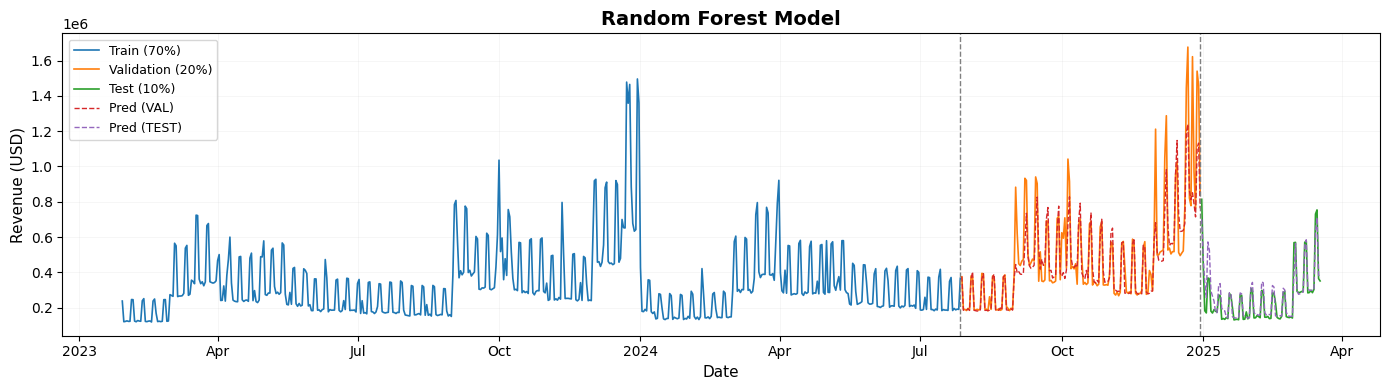

In [ ]:
# ======================= Cell 8: Consolidated Train/Val/Test time-series plot (USD) ======================= #
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

def plot_train_val_test_time_series(ytr, yva, yte, pva=None, pte=None, title="Random Forest Model"):
    # đảm bảo index theo thứ tự thời gian
    ytr = ytr.sort_index()
    yva = yva.sort_index()
    yte = yte.sort_index()

    fig, ax = plt.subplots(figsize=(14,4))
    lw = 1.2

    # vẽ từng segment (màu giống minh họa: blue/orange/green)
    ax.plot(ytr.index, ytr.values, label="Train (70%)", linewidth=lw)
    ax.plot(yva.index, yva.values, label="Validation (20%)", linewidth=lw)
    ax.plot(yte.index, yte.values, label="Test (10%)", linewidth=lw)

    # nếu có dự báo cho validation/test thì vẽ dạng dashed
    if 'pva' in globals() and pva is not None:
        ax.plot(yva.index, pva, linestyle='--', linewidth=1.0, label="Pred (VAL)")
    if 'pte' in globals() and pte is not None:
        ax.plot(yte.index, pte, linestyle='--', linewidth=1.0, label="Pred (TEST)")

    # vertical separators (ngay sau cuối train, ngay sau cuối val)
    try:
        xsep1 = ytr.index[-1]
        xsep2 = yva.index[-1]
        ax.axvline(xsep1, color='gray', linestyle='--', linewidth=1.0)
        ax.axvline(xsep2, color='gray', linestyle='--', linewidth=1.0)
    except Exception:
        pass

    # format trục x (ngày/tháng), auto locator
    locator = mdates.AutoDateLocator()
    fmt = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(fmt)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel("Revenue (USD)", fontsize=11)
    ax.set_xlabel("Date", fontsize=11)

    ax.grid(alpha=0.18, linestyle='-', linewidth=0.4)
    ax.legend(loc='upper left', fontsize=9)
    plt.tight_layout()
    plt.show()

# Gọi hàm (giữ tên biến ytr/yva/yte/pva/pte từ notebook)
plot_train_val_test_time_series(ytr=ytr, yva=yva, yte=yte, pva=globals().get('pva', None), pte=globals().get('pte', None), title="Random Forest Model")
